# Esercitazione 12
L'esercitazione 12 richiede di costruire una DNN e una CNN che sappiano risolvere un problema di classificazione di cifre scritte a mano. In particolare, si richiede di costruire _Deep Neural Networks_ con vari ottimizzatori e di confrontarne le prestazioni con una _Convolutional Neural Network_, sia su dati di validazione presi dallo stesso dataset di quelli di training, sia su dati nuovi (cifre scritte da me).

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt

2023-11-26 14:48:11.971084: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 14:48:12.195529: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 14:48:12.197625: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-26 14:48:13.637645: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


##  Esercizio 12.1
Nell'esercizio si richiede di costruire una Deep Neural Network trovando il giusto optimizer e evolvendo il sistema per un congruo numero di epoche. Dato che i dati di training e di validazione sono immagini $28\times28$ pixel, occorre che vengano prima trasformati in vettori prima di essere dat in input a una DNN.

In [2]:

seed=0
np.random.seed(seed) # fisso un seed per i numeri random
tf.random.set_seed(seed)

from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print('Before reshape:')
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()

# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('After reshape:')
print('X_train shape:', X_train.shape)


# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('Y_train shape:', Y_train.shape)

Before reshape:
X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

After reshape:
X_train shape: (60000, 784)
Y_train shape: (60000, 10)


Si può quidi vedere che i valori di input passano da essere matrici a vettori, mentre gli output passano da essere solo un numero ad essere un vettore di 10 elementi di cui solo uno è diverso da 0, nella posizione corrispondente alla cifra che rappresenta.

Passando alla costruzione della rete, ho scelto di utilizzare _SDG_, _Adam_ e _RMSprop_ come ottimizzatori in 3 reti neurali della stessa struttura. SGD è l'ottimizzatore puù semplice, dato che è il classico Stochastic Gradient Descent; Adam e RMSprop hanno invece una struttura più complessa, che tiene conto anche dell'evoluzione dei parametri durante l'allenamento: per tale motivo mi aspetto che abbiano prestazioni migliori.

La DNN è composta da due layer nascosti ed è così strutturata:
- un layer di input di 400 neuroni che prendono in ingresso $28^2$ variabili e hanno _ReLU_ come funzione di attivazione;
- un secondo layer di 100 neuroni con funzione di attivazione _ReLU_;
- un layer di output di 10 neuroni con funzione di attivazione _softmax_.

La funzione di attivazione _softmax_ permette di trasformare gli input in una probabilità normalizzata su tutti i 10 output. 
Per migliorare l'efficienza della rete e diminuire la possibilità di overfitting, ho aggiunto una probabilità di Dropout, cioè di spegnere i neuroni, di 0.5 per ogni batch.

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model


from keras.optimizers import SGD, Adam, RMSprop

def compile_model_SDG():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['acc'])
    return model

def compile_model_Adam():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adam(),
                  metrics=['acc'])
    return model

def compile_model_RMSprop():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=RMSprop(),
                  metrics=['acc'])
    return model


Ho allenato le tre reti per 10 epoche su batch di 32 dati di input.

In [4]:
# training parameters
batch_size = 32
epochs = 10

# create the deep neural net
model_DNN_SDG = compile_model_SDG()
model_DNN_Adam = compile_model_Adam()
model_DNN_RMSprop =compile_model_RMSprop()

# train DNN and store training info in history
print('model with SDG training: ')
history_SDG = model_DNN_SDG.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

print('model with Adam training: ')
history_Adam = model_DNN_Adam.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

print('model with RMSprop trainig: ')
history_RMSprop = model_DNN_RMSprop.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

model with SDG training: 
Epoch 1/10


2023-11-26 14:48:17.502479: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1874/1875 [============================>.] - ETA: 0s - loss: 0.7660 - acc: 0.7732

2023-11-26 14:48:24.648419: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


1875/1875 [==============================] - 8s 4ms/step - loss: 0.7658 - acc: 0.7733 - val_loss: 0.3163 - val_acc: 0.9128
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3831 - acc: 0.8913 - val_loss: 0.2392 - val_acc: 0.9331
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3102 - acc: 0.9122 - val_loss: 0.2006 - val_acc: 0.9424
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2678 - acc: 0.9243 - val_loss: 0.1738 - val_acc: 0.9484
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2352 - acc: 0.9344 - val_loss: 0.1573 - val_acc: 0.9532
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2119 - acc: 0.9407 - val_loss: 0.1438 - val_acc: 0.9573
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1906 - acc: 0.9457 - val_loss: 0.1319 - val_acc: 0.9597
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - los

2023-11-26 14:49:27.525905: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1873/1875 [============================>.] - ETA: 0s - loss: 0.2854 - acc: 0.9159

2023-11-26 14:49:35.391803: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


1875/1875 [==============================] - 8s 4ms/step - loss: 0.2852 - acc: 0.9160 - val_loss: 0.1071 - val_acc: 0.9661
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1234 - acc: 0.9640 - val_loss: 0.0949 - val_acc: 0.9706
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0887 - acc: 0.9739 - val_loss: 0.0884 - val_acc: 0.9747
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0695 - acc: 0.9796 - val_loss: 0.0900 - val_acc: 0.9756
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0558 - acc: 0.9829 - val_loss: 0.0738 - val_acc: 0.9809
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0469 - acc: 0.9862 - val_loss: 0.0824 - val_acc: 0.9784
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0432 - acc: 0.9868 - val_loss: 0.0740 - val_acc: 0.9801
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - los

2023-11-26 14:50:45.103077: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 10s 5ms/step - loss: 0.2848 - acc: 0.9184 - val_loss: 0.1391 - val_acc: 0.9636
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1553 - acc: 0.9617 - val_loss: 0.1146 - val_acc: 0.9728
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1436 - acc: 0.9681 - val_loss: 0.1241 - val_acc: 0.9743
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1370 - acc: 0.9709 - val_loss: 0.1277 - val_acc: 0.9744
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1474 - acc: 0.9715 - val_loss: 0.1569 - val_acc: 0.9748
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1453 - acc: 0.9727 - val_loss: 0.1504 - val_acc: 0.9762
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1539 - acc: 0.9728 - val_loss: 0.1814 - val_acc: 0.9760
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - lo

In [5]:
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols) #this to do the next segment multiple times

313/313 [==============================] - 1s 2ms/step


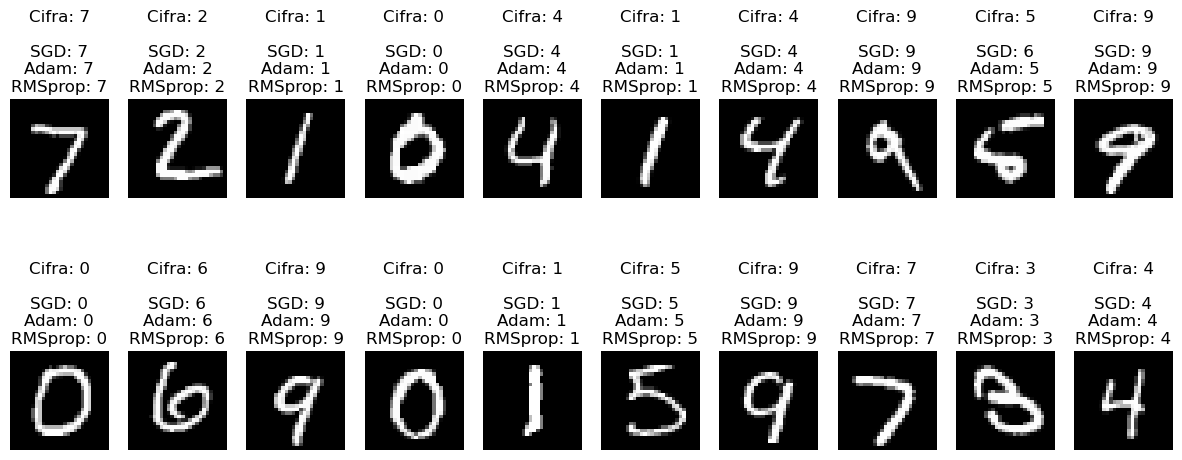

In [6]:
predictions = model_DNN_SDG.predict(X_test)
predictions2 = model_DNN_Adam.predict(X_test)
predictions3 = model_DNN_RMSprop.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 6)) 
for i in range(20):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')
    plt.title("Cifra: {}\n\nSGD: {}\nAdam: {}\nRMSprop: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i]), np.argmax(predictions2[i]), np.argmax(predictions3[i])))        
    plt.axis('off')
plt.show()

Come si può vedere qui sopra, sia il modello con RMSprop che il modello con Adam sono riusciti a predire correttamente tutti i numeri. Tuttavia, il modello con SDG è riuscito a predire ogni tipologia di cifra almeno una volta.

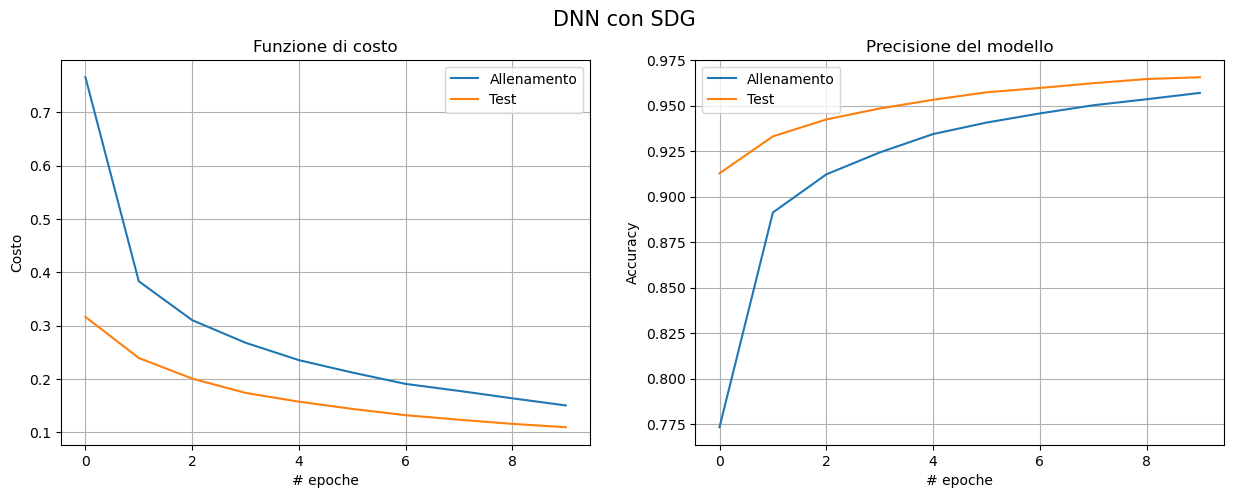

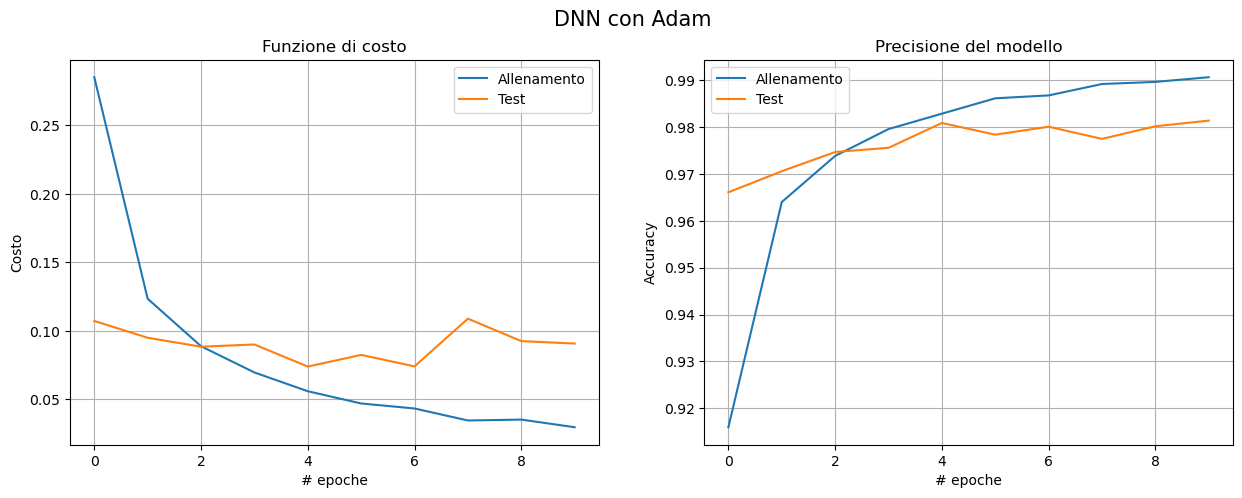

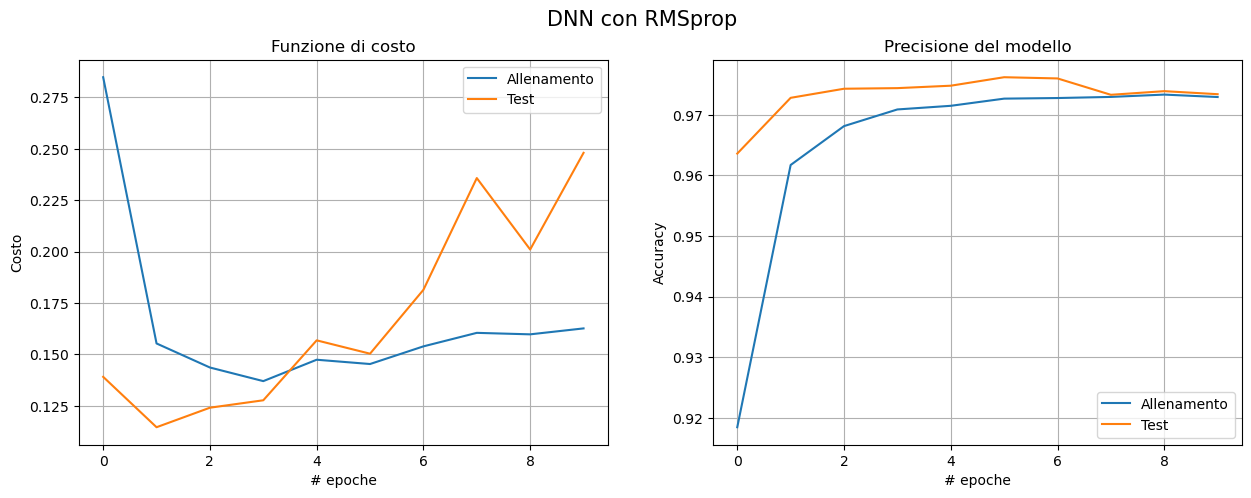

In [7]:
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)


fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('DNN con SDG', size=15)

ax0.plot(history_SDG.history['loss'])
ax0.plot(history_SDG.history['val_loss'])
ax0.set_title('Funzione di costo')
ax0.set_ylabel('Costo')
ax0.set_xlabel('# epoche')
ax0.legend(['Allenamento', 'Test'], loc='best')
ax0.grid()

ax1.plot(history_SDG.history['acc'])
ax1.plot(history_SDG.history['val_acc'])
ax1.set_title('Precisione del modello')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('# epoche')
ax1.legend(['Allenamento', 'Test'], loc='best')
ax1.grid()

plt.show()


fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('DNN con Adam', size=15)

ax0.plot(history_Adam.history['loss'])
ax0.plot(history_Adam.history['val_loss'])
ax0.set_title('Funzione di costo')
ax0.set_ylabel('Costo')
ax0.set_xlabel('# epoche')
ax0.legend(['Allenamento', 'Test'], loc='best')
ax0.grid()

ax1.plot(history_Adam.history['acc'])
ax1.plot(history_Adam.history['val_acc'])
ax1.set_title('Precisione del modello')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('# epoche')
ax1.legend(['Allenamento', 'Test'], loc='best')
ax1.grid()

plt.show()


fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('DNN con RMSprop', size=15)

ax0.plot(history_RMSprop.history['loss'])
ax0.plot(history_RMSprop.history['val_loss'])
ax0.set_title('Funzione di costo')
ax0.set_ylabel('Costo')
ax0.set_xlabel('# epoche')
ax0.legend(['Allenamento', 'Test'], loc='best')
ax0.grid()

ax1.plot(history_RMSprop.history['acc'])
ax1.plot(history_RMSprop.history['val_acc'])
ax1.set_title('Precisione del modello')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('# epoche')
ax1.legend(['Allenamento', 'Test'], loc='best')
ax1.grid()
plt.show()

Dagli andamenti di loss e accuracy lungo le epoche di training si vede che la rete con Adam va in overfitting già dopo due epoche, e analogamente la rete con RMSprop dopo circa 4 epoche. Il modello con lo SGD invece non mostra overfitting nelle 10 epoche di allenamento fatte. Dal grafico sulla precizione dei modelli si può vedere che la rete con Adam è la più accurata dei tre, con una accuracy sui dati di test attorno al $98\%$. Al secondo posto si trova RMSprop, con una accuracy $\sim97.5\%$, mentre SGD si ferma a circa il $97\%$. Adam si mostra essere quindi l'ottimizzatore più efficiente e accurato tra quelli provati.

## Esercizio 12.2
L'esercizio richiede di costruire una _Convolutional Neural Network_ per risolvere lo stesso problema di classificazione di prima: per questo motivo, i dati vanno riportati alla forma originaria. 

In [8]:
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)


Ho costruito una CNN così composta:
- un layer convoluzionale di 10 filtri $5\times5$ con attivazione _ReLU_;
- un layer di Pooling con finestre di dimensione $2\times2$;
- un layer convoluzionale di 64 filtri $3\times3$ con attivazione _ReLU_;
- un altro layer di Pooling con finestre $2\times2$;
- uno layer di appiattimento per passare ad un layer di neuroni "classico";
- un layer di 128 neuroni con funzione di attivazione _ReLU_;
- un layer di output di 10 neuroni con funzione di attivazione _softmax_.

L'ottimizzatore scelto è stato Adam, mentre la funzione costo è stata la _categorical crossentropy_.

In [9]:
def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5), activation='relu', input_shape=input_shape))

    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['acc'])
    return model

La rete è stata allenata per 10 epoche su batch di 32 dati di input.

In [10]:
batch_size = 32
epochs = 10

# create the deep conv net
model_CNN=create_CNN()

# train CNN
history_CNN = model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1812 - acc: 0.9436 - val_loss: 0.0457 - val_acc: 0.9848
Epoch 2/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0650 - acc: 0.9789 - val_loss: 0.0363 - val_acc: 0.9873
Epoch 3/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0498 - acc: 0.9840 - val_loss: 0.0283 - val_acc: 0.9908
Epoch 4/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0421 - acc: 0.9866 - val_loss: 0.0279 - val_acc: 0.9910
Epoch 5/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0357 - acc: 0.9887 - val_loss: 0.0242 - val_acc: 0.9918
Epoch 6/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0310 - acc: 0.9901 - val_loss: 0.0222 - val_acc: 0.9932
Epoch 7/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0290 - acc: 0.9907 - val_loss: 0.0238 - val_acc: 0.9925
Epoch 8/10
1875/1875 [==========================

313/313 [==============================] - 2s 5ms/step


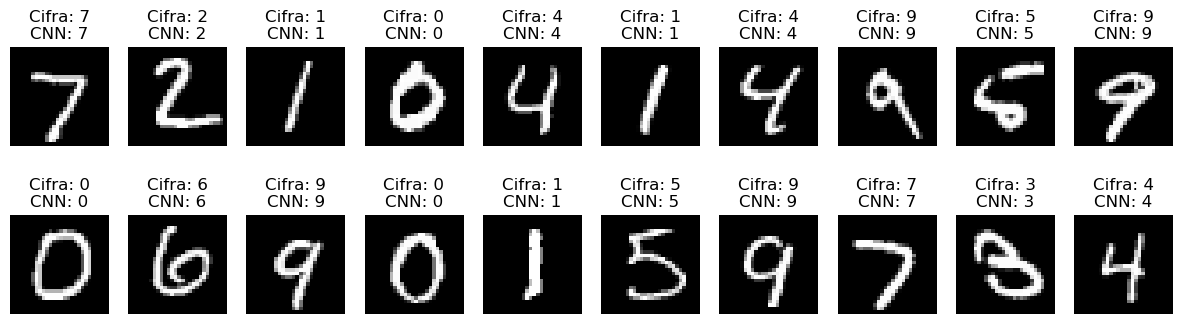

In [11]:
predictions4 = model_CNN.predict(X_test)

plt.figure(figsize=(15, 4)) 
for i in range(20):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')
    #if i<10:
    plt.title("Cifra: {}\nCNN: {}".format(np.argmax(Y_test[i]), np.argmax(predictions4[i])))        
    plt.axis('off')
plt.show()



La rete predice correttamente tutte le cifre proposte nel test.

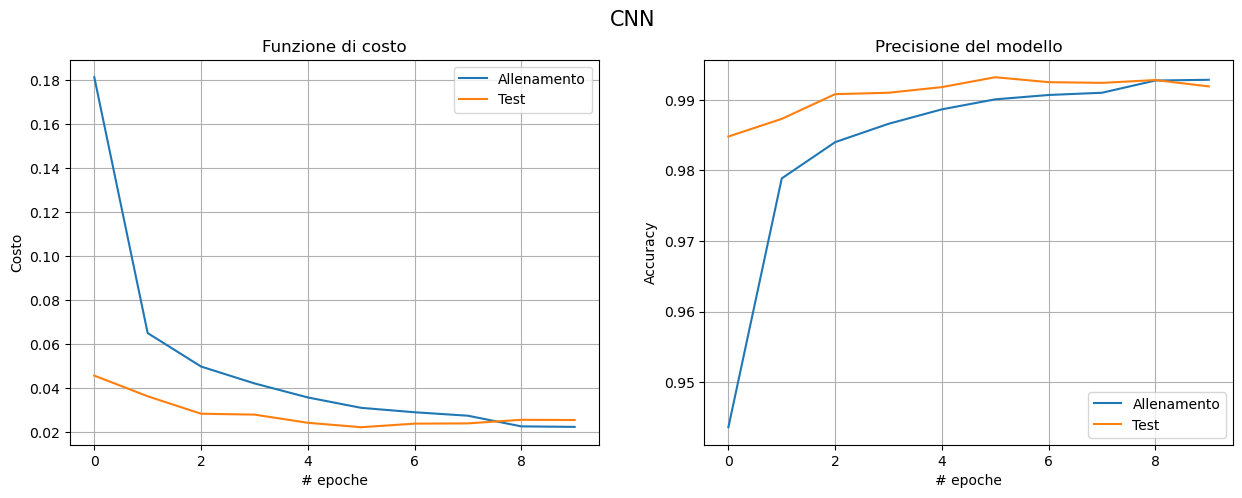

In [12]:
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('CNN', size=15)

ax0.plot(history_CNN.history['loss'])
ax0.plot(history_CNN.history['val_loss'])
ax0.set_title('Funzione di costo')
ax0.set_ylabel('Costo')
ax0.set_xlabel('# epoche')
ax0.legend(['Allenamento', 'Test'], loc='best')
ax0.grid()

ax1.plot(history_CNN.history['acc'])
ax1.plot(history_CNN.history['val_acc'])
ax1.set_title('Precisione del modello')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('# epoche')
ax1.legend(['Allenamento', 'Test'], loc='best')
ax1.grid()

plt.show()

Facendo riferimento ai grafici della funzione costo e dell'accuracy, la CNN sembra iniziare ad avere overfitting dopo 7 epoche, pur mantenendo un valore di costo inferiore a tutte le DNN testate e con una precisione che supera il $99\%$ sui dati di test. Anche se non è la rete più efficiente dal punto di vista computazionale, è sicuramente la più accurata a parità di epoche e dati di allenamento.

## Esercizio 12.3
L'esercizio richiedeva di testare le reti neurali costruite e allenate sul database del MNIST su numeri scritti a mano non apparteneti al database. Ho scritto a mano, su spazi di $28\times28$ pixel ed in scala di grigi, le 10 cifre da sottoporre alle reti.

In [13]:
from PIL import Image
import os

digit_in = []
data = []
pix = []

for i in range(10):
    digit_filename = "./Pictures/"+str(i)+".png"
    digit_in.append(Image.open(digit_filename).convert('L'))
    ydim, xdim = digit_in[i].size
    pix.append(digit_in[i].load());
    data.append(np.zeros((xdim, ydim)))
    for j in range(ydim):
        for k in range(xdim):
            data[i][k,j]=pix[i][j,k]
    data[i] /= 255

'''
plt.figure(figsize=(5,5))
plt.imshow(data[0], cmap='gray')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(data[9], cmap='gray')
plt.show()
'''

"\nplt.figure(figsize=(5,5))\nplt.imshow(data[0], cmap='gray')\nplt.show()\n\nplt.figure(figsize=(5,5))\nplt.imshow(data[9], cmap='gray')\nplt.show()\n"

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 24ms/step


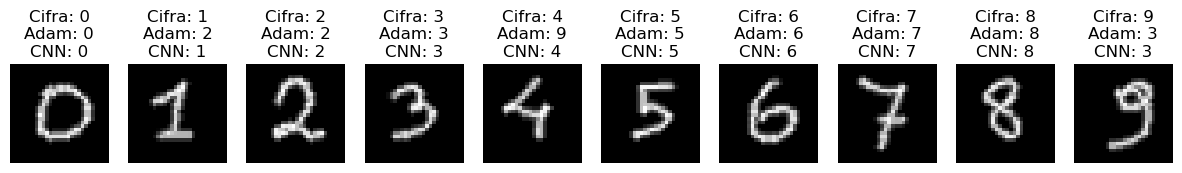

In [14]:
pred_DNN = []
pred_CNN = []


for i in range(10):
    data[i] = data[i].reshape(1,xdim,ydim,1)
    pred_CNN.append(model_CNN.predict(data[i]))
    data[i] = data[i].reshape(1,xdim*ydim)
    pred_DNN.append(model_DNN_Adam.predict(data[i]))
    data[i] = data[i].reshape(xdim,ydim)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(data[i], cmap='gray')
    plt.title("Cifra: {}\nAdam: {}\nCNN: {}".format(i, np.argmax(pred_DNN[i]), np.argmax(pred_CNN[i])))        
    plt.axis('off')
plt.show()


La DNN con Adam fallisce nel riconoscere il mio 1 e il mio 4, impresa invece riuscita alla CNN. Entrambe le reti non riescono tuttavia a riconoscere il 9, e questo potrebbe lasciar intendere che il mio modo di disegnare il 9 non è presente nel database in cui sono state allenate. È anche possibile che giochi un ruolo non indifferente la centratura delle cifre nello spazio di scrittura. Entrambe le reti riescono tuttavia a predire correttamente più del 50% delle cifre.